In [96]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit tests (Making sure that code works as intended)

## Unit test 1: Gaussian family VI to learn known Gaussian posterior
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

0: mu=tensor([0.1000, 0.9000]), sigma=0.900, elbo=-1.28
5000: mu=tensor([0.7000, 0.3000]), sigma=0.478, elbo=0.30
10000: mu=tensor([0.3900, 0.6100]), sigma=0.305, elbo=0.03
15000: mu=tensor([0.5900, 0.4100]), sigma=0.343, elbo=0.19
20000: mu=tensor([0.3700, 0.6300]), sigma=0.600, elbo=0.32
25000: mu=tensor([0.6400, 0.3600]), sigma=0.571, elbo=0.35
30000: mu=tensor([0.5600, 0.4400]), sigma=0.355, elbo=0.26
35000: mu=tensor([0.5000, 0.5100]), sigma=0.509, elbo=0.45
40000: mu=tensor([0.5200, 0.4900]), sigma=0.540, elbo=0.43
45000: mu=tensor([0.5800, 0.4200]), sigma=0.406, elbo=0.34
50000: mu=tensor([0.4400, 0.5400]), sigma=0.569, elbo=0.40
55000: mu=tensor([0.5600, 0.4400]), sigma=0.472, elbo=0.43
60000: mu=tensor([0.5200, 0.5000]), sigma=0.448, elbo=0.43
65000: mu=tensor([0.5200, 0.5100]), sigma=0.519, elbo=0.45
70000: mu=tensor([0.5500, 0.4600]), sigma=0.539, elbo=0.44
75000: mu=tensor([0.4900, 0.4900]), sigma=0.511, elbo=0.45
80000: mu=tensor([0.5000, 0.5300]), sigma=0.464, elbo=0.44
8

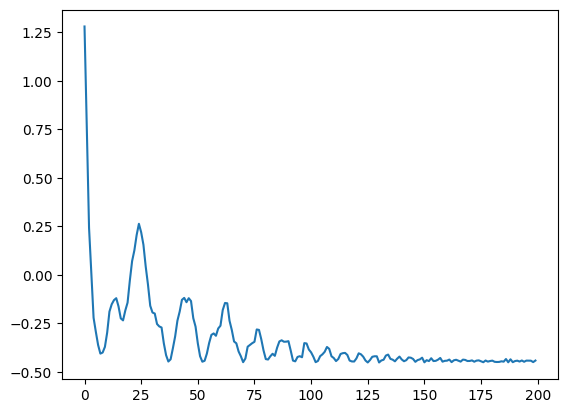

In [140]:
mu_0 = torch.tensor([0.5, 0.5])
sigma_0 = torch.tensor([0.5])

mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
logsigma = nn.Parameter(torch.tensor([np.log(0.9)], dtype=torch.float))
lr = 0.0001
optim = torch.optim.Adam([mu, logsigma], lr=lr)
num_epoch = 100000
S = 2000
num_snapshots = 200
snapshots = []
rec = []
for epoch in range(num_epoch):
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    xi = q.rsample((S, ))
    term1 = q.log_prob(xi)
    term2 = torch.sum((xi - mu_0)**2, dim=1) / (2 * sigma_0**2)
    neg_elbo = torch.mean(term1 + term2)
    neg_elbo.backward()
    optim.step()
    
    if epoch % (num_epoch // num_snapshots) == 0:
        snapshots.append([epoch, mu.clone().detach(), logsigma.clone().detach(), -neg_elbo.detach()])
    
    if epoch % 500 == 0:
        rec.append(neg_elbo.detach())
    
    if epoch % (num_epoch // 20) == 0:
        print(
            f"Epoch {epoch:5d}: mu={np.around(mu.detach(), 2)}, "
            f"sigma={torch.exp(logsigma).item():.3f}, elbo={-neg_elbo:.2f}"
        )

plt.plot(rec)

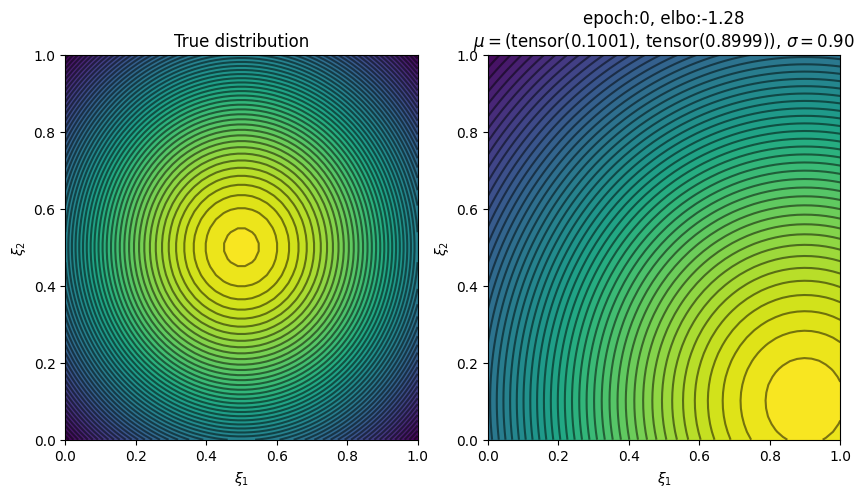

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
N = 50
levels = 50
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))

ax = axes[0]
q = tdist.MultivariateNormal(loc=mu_0, covariance_matrix=torch.eye(2) * sigma_0)
z = np.exp(q.log_prob(torch.tensor(np.stack([xx, yy])).T))
ax.contourf(xx, yy, z, levels=levels)
ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title("True distribution")

ax = axes[1]
epoch, mu, logsigma, elbo = snapshots[0]
q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
z = np.exp(q.log_prob(torch.tensor(np.stack([xx, yy])).T))
contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title("True distribution")


def animate(frame_num):
    global ax, contour, contourf
    epoch, mu, logsigma, elbo = snapshots[frame_num]
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    z = np.exp(q.log_prob(torch.tensor(np.stack([xx, yy])).T))
    
    for col in contourf.collections:
        col.remove()
    contourf = ax.contourf(xx, yy, z, levels=levels)
    ax.set_title(f"epoch:{epoch}, elbo:{elbo:.2f}\n$\\mu=${(mu[0], mu[1])}, $\\sigma=${torch.exp(logsigma).item():.2f}")
    
    for col in contour.collections:
        col.remove()
    contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
    return contour, contourf

anim = animation.FuncAnimation(fig, animate, frames=len(snapshots), interval=300)
video = anim.to_html5_video()
IPython.display.display(IPython.display.HTML(video))


## Unit test 2: Mean field generalised gamma family to learn mean field generalised gamma

# Experiment 1: Learning 2D standard form posterior 

## Experiment 1.0: Learning with Gaussian Family

We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [90]:
N = 200
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))


@interact(
    n=(2, 10000),
    k1=(0, 5),
    k2=(0, 5),
    h1=(0, 5),
    h2=(0, 5)
)
def _plot_contour(n=500, k1=2, k2=3, h1=1, h2=2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z = np.abs((xx ** h1) * (yy ** h2)) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
    normalising_const = np.sum(z) / (N**2)
    
    lambdas = np.array([(h1 + 1) / (2 * k1), (h2 + 1) / (2 * k2)])
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct) 
        - np.log(scipy.special.factorial(m -1)) 
        - np.log(2 * k1) - np.log(2 * k2)
    )
    ks = [k1, k2]
    hs = [h1, h2]
    j = np.argmax(lambdas)
    if m == 1:
        const_term -= np.log(-2 * rlct * ks[j] + hs[j] + 1)
    print(
        f"-logZ = {-np.log(normalising_const)}\n"
        f"RLCT  = {rlct}\n"
        f"m     = {m}\n"
        f"const = {const_term}\n"
        f"rlct log(n) - (m - 1) log log n = {rlct * np.log(n) - (m -1) * np.log(np.log(n))}"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=500, description='n', max=10000, min=2), IntSlider(value=2, description=…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

## Gaussian Variational Family
We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

0: mu=tensor([0.1000, 0.9000]), sigma=0.300, elbo=-27.84
5000: mu=tensor([-0.0200,  0.3200]), sigma=0.169, elbo=-5.81
10000: mu=tensor([0.5500, 0.2600]), sigma=0.103, elbo=-5.35
15000: mu=tensor([0.9500, 0.2800]), sigma=0.063, elbo=-5.79
20000: mu=tensor([ 1.4000, -0.2600]), sigma=0.039, elbo=-6.90
25000: mu=tensor([ 1.0800, -0.1800]), sigma=0.024, elbo=-8.00
30000: mu=tensor([0.5900, 0.4200]), sigma=0.017, elbo=-7.97
35000: mu=tensor([0.0800, 0.9200]), sigma=0.012, elbo=-8.77
40000: mu=tensor([-0.0700,  1.4200]), sigma=0.020, elbo=-7.18
45000: mu=tensor([-0.0500,  1.9200]), sigma=0.035, elbo=-6.58
50000: mu=tensor([0.0800, 2.4200]), sigma=0.044, elbo=-15.95
55000: mu=tensor([0.0800, 2.9100]), sigma=0.023, elbo=-26.37
60000: mu=tensor([-0.0600,  3.4000]), sigma=0.013, elbo=-22.17
65000: mu=tensor([0.0400, 3.8900]), sigma=0.008, elbo=-14.19
70000: mu=tensor([0.0400, 4.3800]), sigma=0.005, elbo=-19.98
75000: mu=tensor([0.0300, 4.8700]), sigma=0.003, elbo=-19.38
80000: mu=tensor([-0.0400,

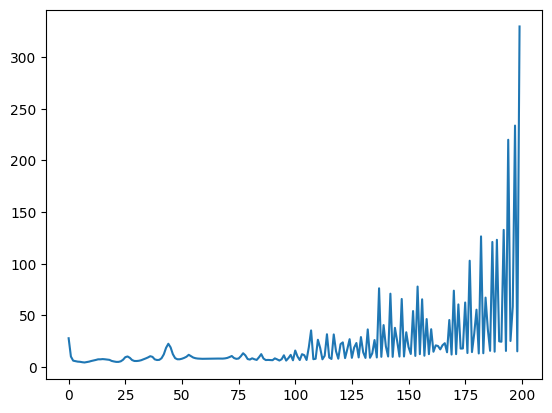

In [142]:
n = 500
k = torch.tensor([2, 3])
h = torch.tensor([1, 2])

mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
logsigma = nn.Parameter(torch.tensor([np.log(0.3)], dtype=torch.float))
lr = 0.0001
optim = torch.optim.Adam([mu, logsigma], lr=lr)
num_epoch = 100000
S = 1000
num_snapshots = 200
snapshots = []
rec = []
for epoch in range(num_epoch):
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    xi = q.rsample((S, ))
    
    term1 = q.log_prob(xi)
    term2 = torch.sum(torch.log(torch.abs(xi)) * h, dim=1)
    term3 = n * torch.prod(xi**(2 * k), dim=1)
    neg_elbo = torch.mean(term1 - term2 + term3)
    neg_elbo.backward()
    optim.step()
    
    if epoch % (num_epoch // num_snapshots) == 0:
        snapshots.append([epoch, mu.clone().detach(), logsigma.clone().detach(), -neg_elbo.detach()])
    
    if epoch % 500 == 0:
        rec.append(neg_elbo.detach())
    
    if epoch % (num_epoch // 20) == 0:
        print(
            f"{epoch}: mu={np.around(mu.detach(), 2)}, "
            f"sigma={torch.exp(logsigma).item():.3f}, elbo={-neg_elbo:.2f}"
        )
plt.plot(rec)


/tmp/ipykernel_1091963/3626736783.py:40: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)


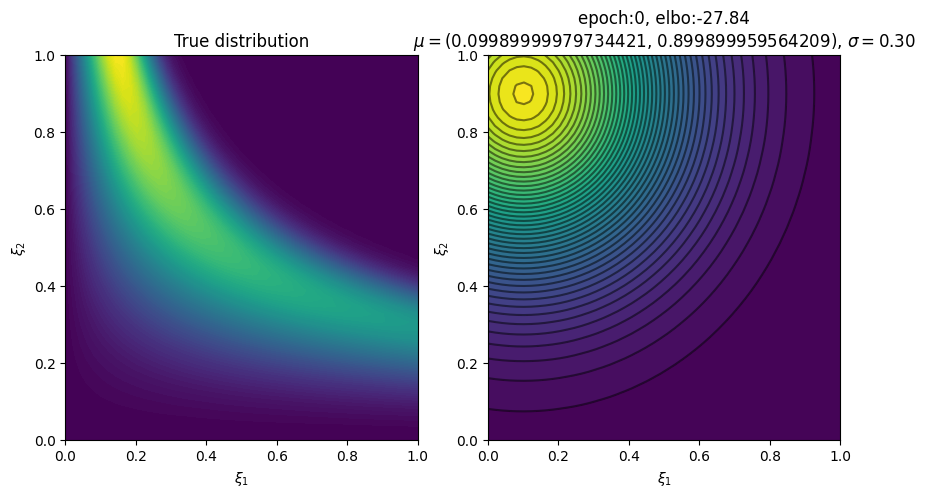

In [154]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
N = 50
levels = 50
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))

ax = axes[0]
k1, k2 = k.numpy()
h1, h2 = h.numpy()
z = np.abs((xx ** h1) * (yy ** h2)) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
normalising_const = np.sum(z) / (N**2)
ax.contourf(xx, yy, z / normalising_const, levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title("True distribution")

ax = axes[1]
epoch, mu, logsigma, elbo = snapshots[0]
sigma = torch.exp(logsigma)
q = tdist.MultivariateNormal(mu, torch.eye(2) * (sigma**2))
z = q.log_prob(torch.tensor(np.stack((xx, yy), axis=-1)))
z = torch.exp(z)
contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")

def animate(frame_num):
    global ax, contour, contourf
    epoch, mu, logsigma, elbo = snapshots[frame_num]
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    z = np.exp(q.log_prob(torch.tensor(np.stack([xx, yy], axis=-1))))
    
    for col in contourf.collections:
        col.remove()
    contourf = ax.contourf(xx, yy, z, levels=levels)
    ax.set_title(
        f"epoch:{epoch}, elbo:{elbo:.2f}\n"
        f"$\\mu=${(mu[0].item(), mu[1].item())}, $\\sigma=${torch.exp(logsigma).item():.2f}"
    )
    
    for col in contour.collections:
        col.remove()
    contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
    return contour, contourf

anim = animation.FuncAnimation(fig, animate, frames=len(snapshots), interval=300)
video = anim.to_html5_video()
IPython.display.display(IPython.display.HTML(video))

# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

n        = 500
lambda_0 = tensor([1., 1.])
ks_0     = tensor([2, 3])

Epoch     0: elbo=-7.64
lambdas=tensor([1., 1.])
ks     =tensor([1., 4.])
betas  =tensor([100.,   1.])

Epoch  2500: elbo=-3.07
lambdas=tensor([1.4100, 1.4400])
ks     =tensor([1.4300, 5.4600])
betas  =tensor([69.4300,  0.6900])

Epoch  5000: elbo=-0.85
lambdas=tensor([1.8600, 1.9300])
ks     =tensor([1.9300, 4.6300])
betas  =tensor([51.0400,  0.5000])

Epoch  7500: elbo=2.84
lambdas=tensor([2.5800, 1.7900])
ks     =tensor([2.5500, 3.2000])
betas  =tensor([38.7100,  0.3800])

Epoch 10000: elbo=27.34
lambdas=tensor([3.8000, 1.3700])
ks     =tensor([3.3200, 2.6100])
betas  =tensor([32.2500,  0.2900])

Epoch 12500: elbo=1835.32
lambdas=tensor([6.1200, 1.0100])
ks     =tensor([4.5100, 3.5900])
betas  =tensor([51.2600,  0.2300])

Epoch 15000: elbo=839991689216.00
lambdas=tensor([14.5700,  0.7600])
ks     =tensor([9.6500, 4.8300])
betas  =tensor([118.4400,   0.1800])

Epoch 17500: elbo=104302911416172544.00
lambdas=tensor(

Text(0.5, 1.0, 'ELBO')

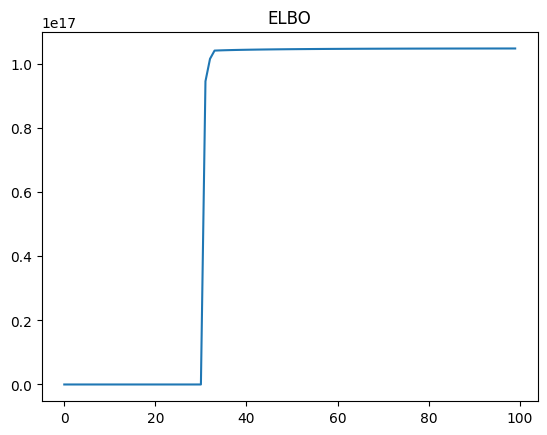

In [157]:
n = 500
k_0 = torch.tensor([2, 3])
h_0 = torch.tensor([1, 2])
lambdas_0 = (h_0 + 1) / k_0 # assume no "flat" dimensions with k_j = 0
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambdas_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
)

loglambdas = nn.Parameter(torch.log(torch.tensor([1.0, 1.0])))
logbetas = nn.Parameter(torch.log(torch.tensor([100., 1.])))
logks = nn.Parameter(torch.log(torch.tensor([1., 4.])))

lr = 0.0001
optim = torch.optim.Adam([loglambdas, logks, logbetas], lr=lr)
num_epoch = 50000
S = 1000

num_snapshots = 200
snapshots = []
rec = []
for epoch in range(num_epoch):
    lambdas = torch.exp(loglambdas)
    ks = torch.exp(logks)
    betas = torch.exp(logbetas)
    
    r = k_0 / ks
    term1 = torch.exp(torch.sum(
        -r * torch.log(betas) +  torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
    ))
    term2 = torch.sum(
        (lambdas - lambdas_0 * r) * torch.exp(torch.lgamma(lambdas)) * (torch.digamma(lambdas) - torch.log(betas))
        - lambdas + lambdas * torch.log(betas) - torch.lgamma(lambdas)
    )
    neg_elbo = term1 + term2
    neg_elbo.backward()
    optim.step()
    
    params_rec = {
        "lambdas": lambdas.clone().detach(),
        "ks": ks.clone().detach(),
        "betas": betas.clone().detach()
    }
    if epoch % (num_epoch // num_snapshots) == 0:
        snapshots.append([epoch, params_rec, -neg_elbo.detach()])
    
    if epoch % 500 == 0:
        rec.append(-neg_elbo.detach())
    
    if epoch % (num_epoch // 10) == 0:
        print(
            f"Epoch {epoch:5d}: elbo={-neg_elbo:.2f}\n"
            f"lambdas={np.around(lambdas.detach(), 2)}\n"
            f"ks     ={np.around(ks.detach(), 2)}\n"
            f"betas  ={np.around(betas.detach(),2)}\n"
        )

fig, ax = plt.subplots(1,1)
ax.plot(rec)
ax.set_title("ELBO")


Text(0, 0.5, '$\\xi_2$')

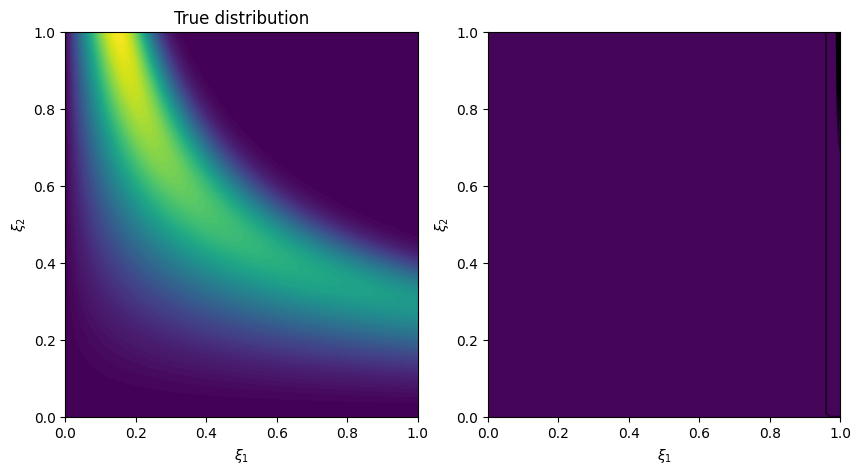

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
N = 100
levels = 50
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))

ax = axes[0]
k1, k2 = k_0.numpy()
h1, h2 = h_0.numpy()
z = np.abs((xx ** h1) * (yy ** h2)) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
normalising_const = np.sum(z) / (N**2)
ax.contourf(xx, yy, z / normalising_const, levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title("True distribution")


ax = axes[1]
epoch, param_rec, elbo = snapshots[-1]
lambdas = param_rec["lambda"].numpy()
ks = param_rec["ks"].numpy()
betas = param_rec["betas"].numpy()
X = np.stack((xx, yy), axis=-1)
# X = np.abs(X)
z = X ** (2 * ks * lambdas - 1) * np.exp(-betas * (X**ks))
normalising_const = betas ** (-lambdas) * scipy.special.gamma(lambdas)
z = np.prod(z / normalising_const, axis=-1)

contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")

In [173]:
def animate(frame_num):
    global ax, contour, contourf, xx, yy, snapshots
    epoch, param_rec, elbo = snapshots[frame_num]
    lambdas = param_rec["lambda"].numpy()
    ks = param_rec["ks"].numpy()
    betas = param_rec["betas"].numpy()
    X = np.stack((xx, yy), axis=-1)
#     X = np.abs(X)
    z = X ** (2 * ks * lambdas - 1) * np.exp(-betas * (X**ks))
    normalising_const = betas ** (-lambdas) * scipy.special.gamma(lambdas)
    z = np.prod(z / normalising_const, axis=-1)

    for col in contourf.collections:
        col.remove()
    contourf = ax.contourf(xx, yy, z, levels=levels)
    ax.set_title(
        f"epoch:{epoch}, elbo:{elbo:.2f}\n"
        f"$\\mu=${(mu[0].item(), mu[1].item())}, $\\sigma=${torch.exp(logsigma).item():.2f}"
    )
    
    for col in contour.collections:
        col.remove()
    contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
    return contour, contourf

anim = animation.FuncAnimation(fig, animate, frames=len(snapshots), interval=300)
video = anim.to_html5_video()
IPython.display.display(IPython.display.HTML(video))

# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family

# Experiment 4: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family